# SIADS 591/592 Project: Crowded Skies: An examination of the characteristics and increasing frequency of UFO sightings  
  
## Christopher Brown: chribrwn
#### This notebook is also available on [github](https://github.com/cb-42/UFO_Report_Analysis/blob/master/ufo_report_analysis.ipynb).  
This notebook contains the main data cleaning, exploration, and analysis workflow for my SIADS 591/592 project. Key sections of this workflow are referenced in the project report, and important visualizations are likewise included.  Note that the webscraping workflow is contained within [nuforc_webscraping_demo.ipynb](https://github.com/cb-42/UFO_Report_Analysis/blob/master/nuforc_webscraping_demo.ipynb) and available within the project submission or on github.

## Links to section headers: <a id='main'></a>
For convenience, I've provided links to the following major manipulation or analysis sections:

### [II. Data Cleaning](#cleaning)
### [III. Total US UFO Reports 1941-2020](#usufos)
### [IV. Reported UFO Sightings Per Million Inhabitants](#sightingspermil)
### [V. Educational Attainment](#edattain)
### [VI. COVID-19 Stringency Index](#covid19si)
### [VII. Supplemental Analyses](#supplemental)

# I. Library & Data Imports  
This section contains the necessary commands for loading vital libraries, setting global parameters, and loading the datasets.  

## 1.1 Library imports, jupyter notebook and visualization parameters  
These cells load the necessary libraries and adjust default notebook/visualization options. Note: you may need to run `pip install <packagename>` if certain libraries haven't been installed in your environment.

In [1]:
# Load manipulation libraries
import numpy as np
import pandas as pd
import re
import datetime as DT

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt # 4.1.2 area plots by region
import plotly.graph_objects as go

# Word Cloud tools
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
# plot params
%matplotlib inline
# or try: notebook

# global matplotlib params
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200

# pd display options
# pd.set_option('display.max_rows', None) # use caution with larger dataframes
pd.set_option('display.max_rows', 20)
# pd.set_option('display.max_colwidth', -1)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)

In [3]:
# word cloud prep
# update stopwords
stopwords = set(STOPWORDS)
stopwords.update(["PD"]) # PD seem to be the initials of a NUFORC reviewer #"said", "NUFORC Note"
ufo_im = np.array(Image.open("data/noun_ufo_469455.png")) # ufo by Gregor Cresnar from the Noun Project

def word_cloud(sighting_summary, sw=stopwords, img=None, mw=200):
    """
    Takes a column of text from a dataframe and generates a word cloud.
    Supports basic word clouds or creation with a user supplied image.
    
    Example usage:
        word_cloud(ufo_df['Full Summary'])
        word_cloud(ufo_df['Full Summary'], img='ufo_im')
    """
    full_text = " ".join(text for text in sighting_summary)
    if not img: # default wordcloud
        return WordCloud(stopwords=sw, max_words=mw).generate(full_text)
    else: # create wordcloud with provided img
        return WordCloud(stopwords=sw, max_words=mw, mode="RGBA", background_color="white", mask=eval(img)).generate(full_text)

## 1.2 Load Primary Data
The following cells load the four primary data sources: NUFORC Reported UFO Sightings, Annual Estimates of the Resident Population for the United States, Educational Attainment in the United States, and a Coronavirus Government Policy Tracker for the United States. Although datasets could be reacquired via download, I've provided copies of prior downloads within the project submission to mitigate potential issues arising from unexpected changes to any of the data sources. They are also available within the [github repo](https://github.com/cb-42/UFO_Report_Analysis).

In [4]:
# UFO_sightings - use .zip due to github size constraints (> 100 mb unzipped)
raw_ufo_reports = pd.read_csv('data/nuforc_full_summary.zip', low_memory=False) # CB's scraped NUFORC sightings

In [5]:
# Load states/statecode/region dict
# May need to drop AS, GU, MP
%run -i "scripts/states_abr_reg.py"
names={'index':'State', 0:'StateCode', 1:'Region'}
statesdf=pd.DataFrame.from_dict(us_st_abr_reg, orient='index').reset_index().rename(columns=names)
statesdf

State StateCode   Region
0          Alabama        AL    South
1           Alaska        AK     West
2   American Samoa        AS    Other
3          Arizona        AZ     West
4         Arkansas        AR    South
..             ...       ...      ...
51        Virginia        VA    South
52      Washington        WA     West
53   West Virginia        WV    South
54       Wisconsin        WI  Midwest
55         Wyoming        WY     West

[56 rows x 3 columns]

In [6]:
# Load Annual Estimates of Resident Population
# Note: Remove empty row between WY and PR
# Source: https://www.census.gov/newsroom/press-kits/2019/national-state-estimates.html
# url='https://www2.census.gov/programs-surveys/popest/tables/2010-2019/state/totals/nst-est2019-01.xlsx'
# uspop = pd.read_excel(url, header=3, nrows=58, skiprows=[60], usecols=[0,*range(3,13)])

# Pre-downloaded version:
uspop = pd.read_excel("data/nst-est2019-01.xlsx", header=3, nrows=58, skiprows=[60], usecols=[0,*range(3,13)])
# Rename Columns
uspop.columns = ['Name', *'Pop_'+uspop.columns[1:].astype(str)]
# Remove preceeding '.' from State names
uspop.Name = uspop.Name.str.replace('.', '')
uspop

Name   Pop_2010   Pop_2011   Pop_2012   Pop_2013   Pop_2014  \
0   United States  309321666  311556874  313830990  315993715  318301008   
1       Northeast   55380134   55604223   55775216   55901806   56006011   
2         Midwest   66974416   67157800   67336743   67560379   67745167   
3           South  114866680  116006522  117241208  118364400  119624037   
4            West   72100436   72788329   73477823   74167130   74925793   
..            ...        ...        ...        ...        ...        ...   
52     Washington    6742830    6826627    6897058    6963985    7054655   
53  West Virginia    1854239    1856301    1856872    1853914    1849489   
54      Wisconsin    5690475    5705288    5719960    5736754    5751525   
55        Wyoming     564487     567299     576305     582122     582531   
56    Puerto Rico    3721525    3678732    3634488    3593077    3534874   

     Pop_2015   Pop_2016   Pop_2017   Pop_2018   Pop_2019  
0   320635163  322941311  324985539  326687501  328239523  
1    56034684   56042330   56059240   56046620   55982803  
2    67860583   67987540   68126781   68236628   68329004  
3   120997341  122351760  123542189  124569433  125580448  
4    75742555   76559681   77257329   77834820   78347268  
..        ...        ...        ...        ...        ...  
52    7163657    7294771    7423362    7523869    7614893  
53    1842050    1831023    1817004    1804291    1792147  
54    5760940    5772628    5790186    5807406    5822434  
55     585613     584215     578931     577601     578759  
56    3473232    3406672    3325286    3193354    3193694  

[57 rows x 11 columns]

In [7]:
# Load US state college completion rates, 2014-2018
# See .xlsx for additional info: Defining metro area, ACS, etc
us_colcr = pd.read_excel('data/EducationReport.xlsx', skiprows=[0,1,2], nrows=53, header=0, usecols=[0,4,5,9,10,16,17])
names = [name + '_CCR' for name in ['Name', '2000_Overall', '2014-2018_Overall', '2000_Urban', '2014-2018_Urban',
                            '2000_Rural', '2014-2018_Rural']]
us_colcr.columns = names
us_colcr

Name_CCR  2000_Overall_CCR  2014-2018_Overall_CCR  2000_Urban_CCR  \
0   United States          0.244016               0.315259        0.262235   
1         Alabama          0.190347               0.249274        0.217080   
2          Alaska          0.247149               0.292311        0.265576   
3         Arizona          0.235310               0.288755        0.242078   
4        Arkansas          0.166606               0.225889        0.201931   
..            ...               ...                    ...             ...   
48     Washington          0.277315               0.352515        0.286777   
49  West Virginia          0.148316               0.202580        0.170535   
50      Wisconsin          0.224195               0.295223        0.250460   
51        Wyoming          0.219101               0.268891        0.219192   
52    Puerto Rico          0.182777               0.253480        0.185213   

    2014-2018_Urban_CCR  2000_Rural_CCR  2014-2018_Rural_CCR  
0              0.335423        0.149003             0.196209  
1              0.279790        0.115997             0.151788  
2              0.318323        0.209847             0.239411  
3              0.295536        0.124178             0.157504  
4              0.267928        0.121767             0.159796  
..                  ...             ...                  ...  
48             0.363927        0.198132             0.250884  
49             0.229441        0.115334             0.160441  
50             0.325729        0.156313             0.211558  
51             0.259442        0.219061             0.273114  
52             0.256195        0.122238             0.192954  

[53 rows x 7 columns]

In [8]:
# Load COVID-19 Stringency Index, etc
# Source: https://www.bsg.ox.ac.uk/research/research-projects/coronavirus-government-response-tracker
uscov = pd.read_csv('data/OxCGRT_US_latest.csv') # 9/6/20, which covers the latest sighting reports from 9/4/20
# Note: 63 columns, of interest are: RegionCode/RegionName, Date, ConfirmedCases, ConfirmedDeaths, StringencyIndex
uscov.sample(10)

CountryName CountryCode      RegionName RegionCode Jurisdiction  \
11723  United States         USA        Virginia      US_VA    STATE_ALL   
4097   United States         USA         Indiana      US_IN    STATE_ALL   
765    United States         USA        Arkansas      US_AR    STATE_ALL   
11278  United States         USA            Utah      US_UT    STATE_ALL   
6994   United States         USA         Montana      US_MT    STATE_ALL   
12896  United States         USA   West Virginia      US_WV    STATE_ALL   
3908   United States         USA        Illinois      US_IL    STATE_ALL   
11915  United States         USA  Virgin Islands      US_VI    STATE_ALL   
10480  United States         USA  South Carolina      US_SC    STATE_ALL   
6853   United States         USA         Montana      US_MT    STATE_ALL   

           Date  C1_School closing  C1_Flag C1_Notes  C2_Workplace closing  \
11723  20200811                3.0      1.0      NaN                   1.0   
4097   20200407                3.0      1.0      NaN                   3.0   
765    20200116                0.0      NaN      NaN                   0.0   
11278  20200129                0.0      NaN      NaN                   0.0   
6994   20200901                0.0      NaN      NaN                   1.0   
12896  20200526                3.0      1.0      NaN                   2.0   
3908   20200607                3.0      0.0      NaN                   1.0   
11915  20200614                3.0      1.0      NaN                   0.0   
10480  20200818                2.0      0.0      NaN                   0.0   
6853   20200413                3.0      1.0      NaN                   3.0   

       ...  StringencyIndex StringencyIndexForDisplay  StringencyLegacyIndex  \
11723  ...            53.24                     53.24                  59.52   
4097   ...            71.30                     71.30                  72.62   
765    ...             0.00                      0.00                   0.00   
11278  ...             0.00                      0.00                   0.00   
6994   ...            39.81                     39.81                  48.33   
12896  ...            63.89                     63.89                  70.24   
3908   ...            64.81                     64.81                  60.71   
11915  ...            36.11                     36.11                  40.00   
10480  ...            39.81                     39.81                  47.62   
6853   ...            76.85                     76.85                  79.76   

       StringencyLegacyIndexForDisplay GovernmentResponseIndex  \
11723                            59.52                   52.24   
4097                             72.62                   63.46   
765                               0.00                    0.00   
11278                             0.00                    0.00   
6994                             48.33                   46.79   
12896                            70.24                   63.46   
3908                             60.71                   61.54   
11915                            40.00                   25.00   
10480                            47.62                   48.08   
6853                             79.76                   73.72   

       GovernmentResponseIndexForDisplay  ContainmentHealthIndex  \
11723                              52.24                   57.20   
4097                               63.46                   65.91   
765                                 0.00                    0.00   
11278                               0.00                    0.00   
6994                               46.79                   50.76   
12896                              63.46                   70.45   
3908                               61.54                   63.64   
11915                              25.00                   29.55   
10480                              48.08                   47.73   
6853                     

## 1.3 Secondary Datasets  
Additionally, I explored using the following dataset in educational attainment analysis. It contains US state highschool diploma and bachelor's degree completion rates for 2010.

In [9]:
# Load US state highschool/bachelor's degree completion rates, 2010
us_hsbachcr = pd.read_excel('data/cb12-33table1states.xls', header=7, nrows=51, usecols=[0,1,3])
us_hsbachcr.columns = ['State', 'HS grad or higher', 'Bachelor Degree or higher']
us_hsbachcr

State  HS grad or higher  Bachelor Degree or higher
0         Alabama               82.1                       21.9
1          Alaska               91.0                       27.9
2         Arizona               85.6                       25.9
3        Arkansas               82.9                       19.5
4      California               80.7                       30.1
..            ...                ...                        ...
46       Virginia               86.5                       34.2
47     Washington               89.8                       31.1
48  West Virginia               83.2                       17.5
49      Wisconsin               90.1                       26.3
50        Wyoming               92.3                       24.1

[51 rows x 3 columns]

# II. <a id='cleaning'>Data Cleaning</a>
[Top](#main)

This section focuses on data cleaning and manipulation operations that prepare the data for use in downstream visualizations and analyses.

## 2.1 NUFORC Sighting Processing

In [10]:
# Function for cleaning NUFORC sighting data
def clean_nuforc(raw_ufo_df, dropcols=['Posted','URL']):
    """
    Wraps many common UFO report cleaning tasks into a single function.
    
    Arguments:
    raw_ufo_df: Raw NUFORC reports resulting from webscraping operation. Handles zipped CSV file.
        For more information, see nuforc_webscraping_demo.ipynb.
    
    dropcols: List of columns to exclude
    
    Returns:
    A cleaned dataframe of NUFORC UFO Reports, without any columns specified in dropcols.
    
    Example usage: clean_nuforc(raw_ufo_reports)
    """
    
    # Exclude final 142 rows, which are from an 'Unspecified/Approximate' collection. Many of these have poorly
    # formatted or nonexistent Date / Time. Extended to final 172 due to additional suspect Date / Time fields
    df=raw_ufo_df.copy()
    df=df.iloc[1:len(df)-172] # Exclude 30 early/questionably formatted sightings
    
    # Largo, FL is a real place - so let's correct the state abbreviation
    df.loc[df.State == 'Fl', 'State'] = 'FL' # Only 1 occurrence
    # Correct 'M0' to 'MO', based on other reports for the city of Hannibal
    df.loc[df.State == 'M0', 'State'] = 'MO' # Only 1 occurrence
    # Rename `State` for consistency with other dataframes
    df.rename(columns={'State':'StateCode'}, inplace=True)
    
    # Make datetime
    # Consider excluding those with both a missing Shape and Summary (also Duration?)
    df['Datetime'] = pd.to_datetime(df['Date / Time'])
    # Correct 1930-1969 times (2 digit years interpreted as 2069, etc)
    td = pd.Timedelta(days = (100 * 365.24))
    newdates = df[df.iloc[:,0].str.contains('/[3456][0-9] ', regex=True)].Datetime - td
    df.loc[df.iloc[:,0].str.contains('/[3456][0-9] ', regex=True), 'Datetime'] = newdates
    df.set_index('Datetime', inplace=True)
    df = df[df.index.year <= 2020] # Exclude 57 suspicious dates from 2021 and beyond
    df.drop(columns=['Date / Time'], inplace=True)
        
    # Add a NUFORC Note and hoax flags for filtering out suspicious reports
    df['NUFORC_Note'] = df.Summary.str.contains('NUFORC', na=False)
    df['Hoax'] = df.Summary.str.contains('hoax', na=False, flags=re.IGNORECASE, regex=True)
    
    # Convert descriptions to lower case: consolidates unique words for use in word cloud visualizations
    #     df.Summary = df.Summary.str.lower() # Summary is not used in word clouds in current iteration
    df['Full Summary'] = df['Full Summary'].str.lower()
    
    # Use truncated summaries in instances where full report page could not be retreived
    df.loc[df['Full Summary'] == '[[the page cannot be found]]', 'Full Summary'] = \
        df.loc[df['Full Summary'] == '[[the page cannot be found]]', 'Summary']
    
    # Handle missing summary: empty string, so record is usable for counts/shape analysis
    df.loc[df['Full Summary'].isnull(), 'Full Summary'] = ''
    
    # Drop Summary, Posted, URL columns - unused in current analysis
    # Note: In some cases it is useful to retain Summary to examine NUFORC or Hoax-related comments
    if dropcols:
        df.drop(columns=dropcols, inplace=True)
        
    return df


# Create the clean dataframe
ufo_df = clean_nuforc(raw_ufo_reports)
ufo_df

City StateCode      Shape     Duration  \
Datetime                                                                        
2020-09-04 04:58:00                Lakeland        FL   Fireball    4 seconds   
2020-09-04 03:20:00             York County        VA      Other  1-2 seconds   
2020-09-04 03:18:00     Beausejour (Canada)        MB  Formation    5 seconds   
2020-09-04 01:15:00                 Pahrump        NV      Light  2-3 minutes   
2020-09-04 01:00:00            Williamstown        WV   Teardrop      Seconds   
...                                     ...       ...        ...          ...   
2020-08-01 22:40:00             Springfield        MO      Light   60 seconds   
2018-06-12 03:00:00     Wadi Dhahal (Syria)       NaN      Light   30 seconds   
2017-10-13 00:00:00       Fatima (Portugal)       NaN       Disk          NaN   
2017-10-01 22:00:00                 Baldwin        PA       Disk    5 seconds   
2014-12-24 00:00:00  Meeting Creek (Canada)        SK        NaN          NaN   

                                                               Summary  \
Datetime                                                                 
2020-09-04 04:58:00  Bright Falling Green Object In A Moonlit Early...   
2020-09-04 03:20:00  I was heading back from a friends house coming...   
2020-09-04 03:18:00      3 white dots flying East ward in Eastern sky.   
2020-09-04 01:15:00  Blue ziggzaging and sudden stops light that ti...   
2020-09-04 01:00:00  Looked up and caught a glimpse of a light movi...   
...                                                                ...   
2020-08-01 22:40:00  My wife and I were sitting in our garage facin...   
2018-06-12 03:00:00  Brilliant glowing ball crossed the sky silentl...   
2017-10-13 00:00:00  Miracle of the SunFrom Wikipedia, the free enc...   
2017-10-01 22:00:00  Sitting looking out kitchen sliding doors. Obj...   
2014-12-24 00:00:00  I initially submitted this several years ago, ...   

                                                          Full Summary  \
Datetime                                                                 
2020-09-04 04:58:00  bright falling green object in a moonlit early...   
2020-09-04 03:20:00  i was heading back from a friends house coming...   
2020-09-04 03:18:00  3 white dots flying east ward in eastern sky3 ...   
2020-09-04 01:15:00  blue ziggzaging and sudden stops light that ti...   
2020-09-04 01:00:00  looked up and caught a glimpse of a light movi...   
...                                                                ...   
2020-08-01 22:40:00  my wife and i were sitting in our garage facin...   
2018-06-12 03:00:00  brilliant glowing ball crossed the sky silentl...   
2017-10-13 00:00:00  miracle of the sunfrom wikipedia, the free enc...   
2017-10-01 22:00:00  sitting, looking out kitchen sliding doors.  o...   
2014-12-24 00:00:00  i initially submitted this several years ago, ...   

                     NUFORC_Note   Hoax  
Datetime                                 
2020-09-04 04:58:00        False  False  
2020-09-04 03:20:00        False  False  
2020-09-04 03:18:00        False  False  
2020-09-04 01:15:00        False  False  
2020-09-04 01:00:00        False  False  
...                          ...    ...  
2020-08-01 22:40:00        False  False  
2018-06-12 03:00:00        False  False  
2017-10-13 00:00:00        False  False  
2017-10-01 22:00:00        False  False  
2014-12-24 00:00:00        False  False  

[93776 rows x 8 columns]

In [11]:
# Inspect typical values and unique counts
ufo_df.reset_index().describe()

Datetime     City StateCode  Shape   Duration  \
count                 93776    93555     88415  90668      90006   
unique                78898    20010        66     22       8164   
top     2015-11-07 18:00:00  Phoenix        CA  Light  5 minutes   
freq                    104      463     10007  19731       6707   
first   1930-06-30 10:00:00      NaN       NaN    NaN        NaN   
last    2020-09-04 04:58:00      NaN       NaN    NaN        NaN   

               Summary    Full Summary NUFORC_Note   Hoax  
count            93749           93776       93776  93776  
unique           92137           92599           2      2  
top     MADAR Node 142  madar node 142       False  False  
freq                45              45       88893  92433  
first              NaN             NaN         NaN    NaN  
last               NaN             NaN         NaN    NaN

## 2.2 US COVID-19 Data Cleaning/Processing

In [12]:
def clean_uscov(cov, drop_regcode=['US', 'VI']):
    """
    Wraps US COVID-19 data cleaning operations within a single function.
    
    Arguments:
    cov: dataframe containing US COVID-19 government response tracking data
    drop_regcode: RegionCodes to exclude. Change to None to avoid excluding any entities.
    
    Returns:
    Cleaned US COVID-19 data
    
    Example usage:
    clean_uscov(uscov, None)
    """
    def format_date(date):
        return date[0:4]+'-'+date[4:6]+'-'+date[6:8]
    
    covdf = cov.copy()
    
    # Reformat Date column
    covdf['Date'] = pd.to_datetime(covdf['Date'].astype('str').map(format_date))

    # Replace NaN values with US and extract 2 character state Abbreviation
    covdf.loc[covdf['RegionCode'].isnull(), 'RegionCode'] = 'US'
    covdf['RegionCode']=covdf['RegionCode'].map(lambda x: x[-2:])
    
    # Exclude RegionCodes within drop_regcode
    if drop_regcode:
        covdf = covdf[~covdf['RegionCode'].isin(drop_regcode)] #.reset_index()
        
    # Fill missing values: first forward fill by state, which will carry forward existing cases where there are gaps.
        # Works for entries that are recent or between known values, and filling with the previous entry is reasonable.
    # Second, fill remaining missing values with 0s (backfill would also work here)
        # This impacts ConfirmedCases and ConfirmedDeaths before the pandemic began, 0 is a reasonable imputation.
    # RegionCode consumed by the transformation - add it back in with pd.concat
    covdf = pd.concat([covdf.RegionCode, covdf.groupby('RegionCode').transform(lambda x: x.ffill().fillna(0))], 1)
    
    # Keep only selected columns
    # Note: StringencyIndex ever differs from StringencyIndexForDisplay for 230 rows.
    # StringencyIndex has more missing values, therefore use the latter.
    covdf = covdf[['RegionName', 'RegionCode', 'Date', 'ConfirmedCases', 'ConfirmedDeaths',
               'StringencyIndexForDisplay']]
    # Rename SI for cleaner labeling in viz/charts
    covdf.rename(columns={'StringencyIndexForDisplay':'StringencyIndex'}, inplace=True)
    
    return covdf


# Create the clean dataframe
uscov_short = clean_uscov(uscov)
uscov_short

RegionName RegionCode       Date  ConfirmedCases  ConfirmedDeaths  \
250       Alaska         AK 2020-01-01             0.0              0.0   
251       Alaska         AK 2020-01-02             0.0              0.0   
252       Alaska         AK 2020-01-03             0.0              0.0   
253       Alaska         AK 2020-01-04             0.0              0.0   
254       Alaska         AK 2020-01-05             0.0              0.0   
...          ...        ...        ...             ...              ...   
13245    Wyoming         WY 2020-09-02          3911.0             41.0   
13246    Wyoming         WY 2020-09-03          3941.0             41.0   
13247    Wyoming         WY 2020-09-04          3941.0             41.0   
13248    Wyoming         WY 2020-09-05          3941.0             41.0   
13249    Wyoming         WY 2020-09-06          3941.0             41.0   

       StringencyIndex  
250               0.00  
251               0.00  
252               0.00  
253               0.00  
254               0.00  
...                ...  
13245            37.04  
13246            37.04  
13247            37.04  
13248            37.04  
13249            37.04  

[12750 rows x 6 columns]

## 2.3 US UFO Preparation
* This includes removing reports without a US-based state identifier, adding a count column, joining additional identifiers

In [13]:
def prep_us_ufos(clean_ufodf, states=statesdf, startyr=2000, endyr=2020):
    """
    Filter for US sightings, add state and region identifiers.
    
    Arguments:
    clean_ufodf: NUFORC UFO report dataframe resulting from clean_nuforc().
    states: A dataframe resulting from the states_abr_reg.py script.
    startyr: Integer; Lower bound of time interval for retaining UFO reports.
    endyr: Integer; Upper bound of time interval for retaining UFO reports.
    
    Returns:
    A dataframe of UFO reports based in the US, with additional geographic identifiers and filtered 
    to retain only the bounded time interval.
    
    Example usage:
    prep_us_ufos(ufo_df, startyr=2010, endyr=2019)
    """
    
    ufodf = clean_ufodf.copy()
    
    # Restrict sightings based on start/end date
    ufodf = ufodf[(ufodf.index.year >= startyr) & (ufodf.index.year <= endyr)] # trims to roughly 80k records
    
    # Keep US-based reports
    usufodf = pd.merge(ufodf.reset_index(), states, left_on='StateCode', right_on='StateCode').set_index('Datetime')
    
    # Create UFO_count for use in per capita calculations 
    usufodf.insert(loc=usufodf.shape[1], column='UFO_Count', value=1)
    
    # Pop, Ed, COVID-19 are all dependent on particular years - use a separate joining function for these
    return usufodf


# Create the clean dataframe
us_ufos = prep_us_ufos(ufo_df)
us_ufos

City StateCode     Shape  \
Datetime                                                                   
2020-09-04 04:58:00                         Lakeland        FL  Fireball   
2020-09-01 22:15:00                          Parrish        FL  Fireball   
2020-08-29 19:46:00                 North Palm Beach        FL  Fireball   
2020-08-26 21:55:00                      Indialantic        FL  Fireball   
2020-08-20 22:00:00                  Satellite Beach        FL     Light   
...                                              ...       ...       ...   
2006-05-17 00:30:00                 Washington, D.C.        DC  Triangle   
2006-04-16 23:00:00                 Washington, D.C.        DC  Triangle   
2003-11-21 16:00:00                               na        DC       NaN   
2002-08-01 14:30:00  Washington, D.C. to Kansas City        DC  Cylinder   
2001-09-11 09:00:00                 Washington, D.C.        DC    Circle   

                       Duration  \
Datetime                          
2020-09-04 04:58:00   4 seconds   
2020-09-01 22:15:00   5 seconds   
2020-08-29 19:46:00   2 minutes   
2020-08-26 21:55:00        5:00   
2020-08-20 22:00:00  10 minutes   
...                         ...   
2006-05-17 00:30:00  10 seconds   
2006-04-16 23:00:00  20 minutes   
2003-11-21 16:00:00  15 minutes   
2002-08-01 14:30:00  20 minutes   
2001-09-11 09:00:00       1 min   

                                                               Summary  \
Datetime                                                                 
2020-09-04 04:58:00  Bright Falling Green Object In A Moonlit Early...   
2020-09-01 22:15:00                   UFO sighting in parrish Florida.   
2020-08-29 19:46:00                        4 fireballs over night sky!   
2020-08-26 21:55:00   Hovering fireball over Atlantic Ocean in Florida   
2020-08-20 22:00:00  Last night of FL vacation observed a large red...   
...                                                                ...   
2006-05-17 00:30:00  black triangular object with three red lights ...   
2006-04-16 23:00:00  This is my second report of these Triangular s...   
2003-11-21 16:00:00   USO seen my military coming up out of the water.   
2002-08-01 14:30:00  Metallic cylinder shape hovering at 45 degree ...   
2001-09-11 09:00:00        Small orbs circle the pentagon on Sept 11th   

                                                          Full Summary  \
Datetime                                                                 
2020-09-04 04:58:00  bright falling green object in a moonlit early...   
2020-09-01 22:15:00  ufo sighting in parrish florida.driving east o...   
2020-08-29 19:46:00  4 fireballs over night sky!we saw 4 fire type ...   
2020-08-26 21:55:00  hovering fireball over atlantic ocean in flori...   
2020-08-20 22:00:00  last night of fl vacation observed a large red...   
...                                                                ...   
2006-05-17 00:30:00  black triangular object with three red lights ...   
2006-04-16 23:00:00  this is my second report of these triangular s...   
2003-11-21 16:00:00  uso seen my military coming up out of the wate...   
2002-08-01 14:30:00  metallic cylinder shape hovering at 45 degree ...   
2001-09-11 09:00:00  small orbs circle the pentagon on sept 11thifi...   

                     NUFORC_Note   Hoax                 State Region  \
Datetime                                                               
2020-09-04 04:58:00        False  False               Florida  South   
2020-09-01 22:15:00        False  False               Florida  South   
2020-08-29 19:46:00        False  False               Florida  South   
2020-08-26 21:55:00        False  False               Florida  South   
2020-08-20 22:00:00        False  False               Florida  South   
...                          ...    ...                   ...    ...   
2006-05-17 00:30:00        False  False  District of Columbia  South   
2006-04-16 23:00:00        Fa

## 2.4 Sightings per million inhabitants
It was important to scale an area's sightings by the population, and because this was a routine task, I created a function to join US population estimates to US UFO reports and calculate sightings per million inhabitants.

In [14]:
# Function for determining sightings per 1m, given frequency (typically year)
def sightings_ratio(df, year, pop=uspop, locale='State', filt=False, grouper='1Y', pr=False):
    """
    Combine a dataframe containing US NUFORC UFO reports with census population estimates at a specified
    geographic level and time frequency.
    
    Arguments:
    df: Dataframe containing ufo reports, presumably us_ufos, which has been merged with statesdf in prep_us_ufos().
    year: Integer; year to use. Valid years depend on the data included within the pop paramater.
        For uspop they range from 2010 to 2020.
    pop: population reference dataframe. uspop consists of state and regional population estimates.
    locale: String; valid values are State or Region.
    filt: Boolean; whether to subset the data by the given year.
    grouper: String; frequency of grouping. It is important to consider how this will relate to the locale level, as there are
        instances in which states have no observations on some days. It may best to group at weekly
        frequency or higher.
    pr: Boolean; whether to include Puerto Rico.
    
    Returns: 
    Dataframe with UFO sightings per 1 million people and Hoaxes per 1 million people.
    
    Example usage:
    sightings_ratio(us_ufos, year=2019, locale='Region', filt=True, grouper='1Y')
    """
    # Subset dataframe by year if necessary
    if filt:
        df = df[df.index.year == year]
    
    # Exclude PR if requested
    if not pr:
        df = df[df.State != 'Puerto Rico']
    
    # Special handling for 2020, which uses Census Estimate for 2019
    lab = None
    if year == 2020:
        year = 2019
        lab = 'Pop_2020'
    year = 'Pop_'+str(year) # handle 2020
    pop = pop.loc[:,['Name', year]]
        
    # needs to be joined before pop (avoiding adding extra pop)
    df = df.groupby([pd.Grouper(freq=grouper),locale]).agg(np.sum).reset_index()
    df = pd.merge(df, pop, left_on=locale, right_on='Name', how='left').drop(columns=['Name'])
    
    df['UFOSightingsper1M'] = df['UFO_Count']/df[year]*1e6
    df['Hoaxper1M'] = df['Hoax']/df[year]*1e6

    return df

# III. <a id='usufos'>Absolute reported US UFO sightings per year</a>  
[Top](#main)  

I began the analysis by exploring how the frequency of all US UFO reports has changed over time.  
  
## 3.1 Yearly reported US UFO sightings, 1941-2020  
The following visualizations illustrate the dramatic increase in reported UFO sightings in the United States beginning in the mid 2000s. The peak appears to occur in 2015, with a downturn from 2016-2018, though the frequency is still well above any other point prior to the 21st century.

### 3.1.1 Line plot
While this gets the point across, it's a bit difficult to make out the low values in mid 20th century, due in part to the way the plot is padded with white space along the x-axis.

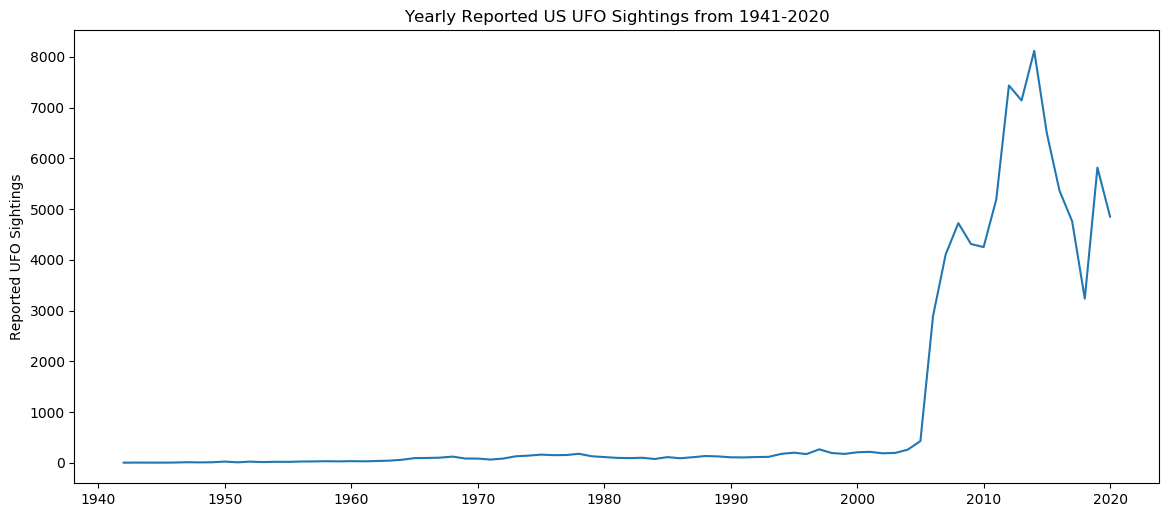

In [15]:
# show num sightings per year: aggregate by Year
us_ufos_yearly = prep_us_ufos(ufo_df, states=statesdf, startyr=1941, endyr=2020) # 1941-2020
us_ufos_yearly = us_ufos_yearly.groupby([pd.Grouper(freq='1Y')]).agg(np.sum)
us_ufos_yearly['Year'] = us_ufos_yearly.index.year

# Create line plot
plt.figure(figsize=(14,6))
ax = sns.lineplot(x='Year', y='UFO_Count', data=us_ufos_yearly)
ax.set_ylabel('Reported UFO Sightings')
ax.set_xlabel(None)
ax.set_title('Yearly Reported US UFO Sightings from 1941-2020');

### 3.1.2 Area plot
An area plot draws the viewers attention to the portion of the visualization with the most color, which is the time period we're ultimately interested in. It's also easier to compare years with lower sighting frequency.

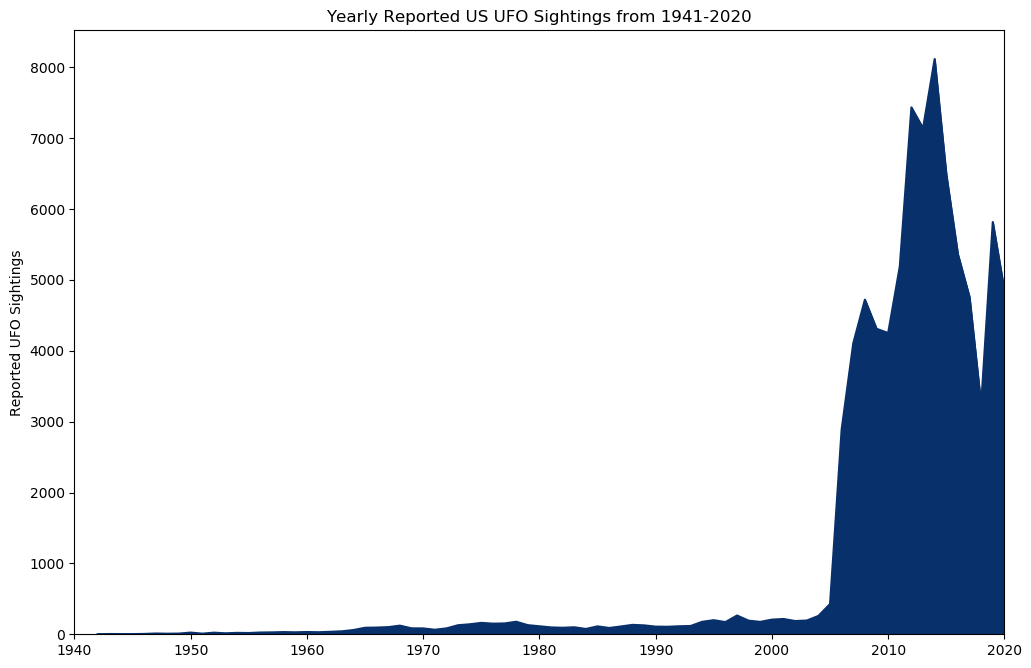

In [16]:
# Create an area plot as a clearer alternative
us_ufos_yearly[['Year', 'UFO_Count']].plot(x='Year', y='UFO_Count', kind='area', legend=None, colormap='Blues_r',
                                          title='Yearly Reported US UFO Sightings from 1941-2020')
plt.ylabel('Reported UFO Sightings') # ylabel param not supported w/ pd.plot(kind='area')
plt.xlabel(None) # Clear that x-axis represents years, given title; xlabel param not supported w/ pd.plot(kind='area')
plt.xlim([1940, 2020]);
# plt.savefig('us_sightings_1941_2020.png') # used in final report

## 3.3 Comparison of Absolute UFO reports, 2019 vs 2020
In this section, I'll compare the absolute number of UFO Reports in the United States in the years 2019 and 2020. Interestingly, there is a spike in total sightings around the time of peak COVID-19 deaths in the US around April 16th, the 107th day of the year.

In [17]:
ufo_us19_20 = us_ufos.loc[(us_ufos.index.year >= 2019),:].copy() # copy necessary to avoid a warning
ufo_us19_20['year'] = ufo_us19_20.index.year
ufo_us19_20['dayofyear'] = ufo_us19_20.index.dayofyear

# show num sightings per day by year
ufo_agg = ufo_us19_20.reset_index().groupby(['year', 'dayofyear']).agg(np.sum).reset_index()

In [18]:
alt.Chart(ufo_agg).mark_line().encode(
    x=alt.X('dayofyear:Q', title='Day of year', scale=alt.Scale(domain=[0, 365])),
    y=alt.Y('UFO_Count:Q', title='UFO Reports'),
    color=alt.Color('year:N', legend=None)
).properties(height=250, width=750, title='Daily US Regional UFO Sightings Per Million Inhabitants in 2019 and 2020')

alt.Chart(...)

## 3.4 Contrasting 2019 and 2020 UFO report descriptions with Word Clouds

In this section, I'll set up the data for use in word clouds and then create word clouds to contrast frequently used words. A key question is whether the words typically used in UFO descriptions during 2019 differ from those in 2020.

The main takeaway: the word clouds for 2019 and 2020 are very similar, so this may not be the best tool for examining collections of data that have minor differences. We'll explore these with other variables later on.

### 3.4.1 Do words used in UFO reports descriptions differ between 2019 and 2020?  
First, we'll examine whether there are any differences in word frequency between the 2019 and 2020. Word frequencies are encoded as the size of the words in the following visualizations. Though there appear some differences in the sizes of words such as *light* and *object*, it's generally difficult to discern major differences. This also suggests that the frequency of commonly used words doesn't differ dramatically between the two years. In section 5, I show a better approach for measuring word frequency differences than using word clouds alone.

In [19]:
us19 = us_ufos[us_ufos.index.year == 2019]
us20 = us_ufos[us_ufos.index.year == 2020]

# prep wordclouds
wc1 = word_cloud(us19['Full Summary']) # ufo icon img could also be used for these
wc2 = word_cloud(us20['Full Summary'])
wcs = [wc1, wc2]

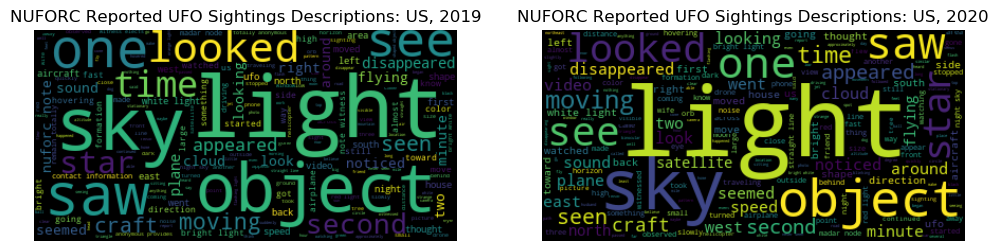

In [20]:
# Show 2 figures in one pane
wc1 = word_cloud(us19['Full Summary'])
wc2 = word_cloud(us20['Full Summary'])

fig, axs = plt.subplots(ncols=2)

titles = ["NUFORC Reported UFO Sightings Descriptions: US, 2019",
          "NUFORC Reported UFO Sightings Descriptions: US, 2020"]

for ax, wc, title in zip(axs.flat, [wc1, wc2], titles):
    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(title)

# IV. <a id='sightingspermil'>Reported UFO Sightings Per Million Inhabitants</a>  
[Top](#main)  

In this section, we'll examine how the scaled frequency of UFO reports varies across geographic areas in the US.
  
## 4.1 Regional UFO reports scaled by population, 2010-2020
Interestingly, the years from 2010-2015 have large spikes in the number of UFO reports around the July 4th Holiday, across all regions. A future investigation may seek to uncover whether there is any relationship between fireworks and UFO sightings. The West most often has the highest sightings ratio, while the South tends to have the lowest.

In [21]:
# Function to create a line plot by region, for a given year
def plot_regional_sighting_freq(df, yvar='UFOSightingsper1M'):
    year = df.Datetime.dt.year[0]
    ax = sns.lineplot(x='Datetime', y=yvar, hue='Region', data=df, palette='viridis')
    ax.set_xlabel(None)
    ax.set_ylabel('Reported UFO Sightings Per Million Inhabitants')
    plt.title('Weekly Reported UFO Sightings in the United States by Region, '+str(year)) # Add year to plot title

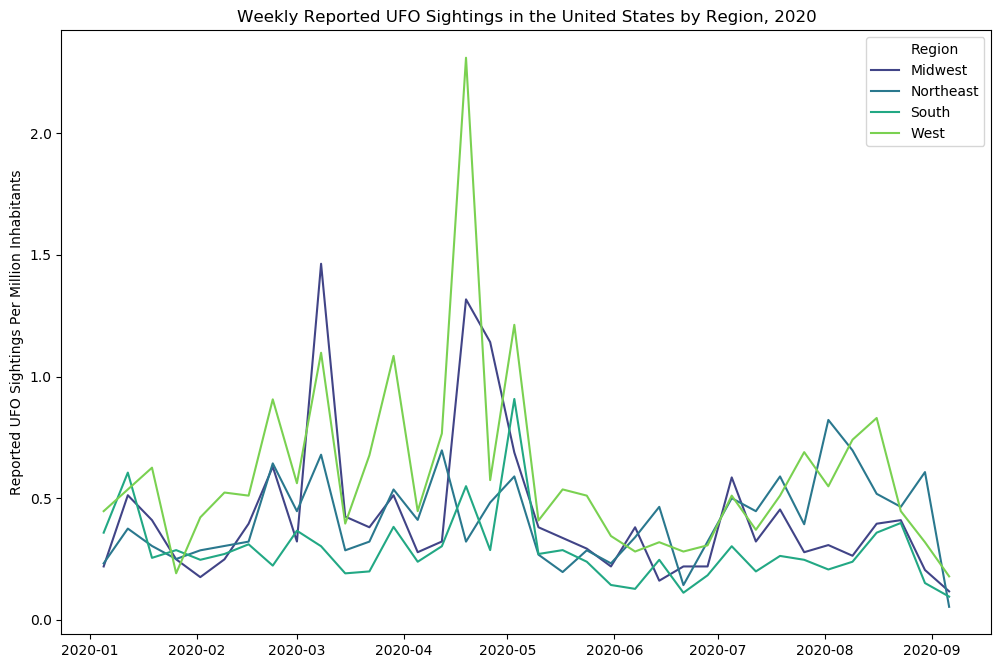

In [22]:
# 2020 - Spike in mid April apparent
df = sightings_ratio(us_ufos, year=2020, locale='Region', filt=True, grouper='1W')
plot_regional_sighting_freq(df)
# plt.savefig('us_regional_sightings_2020.png') # included in report

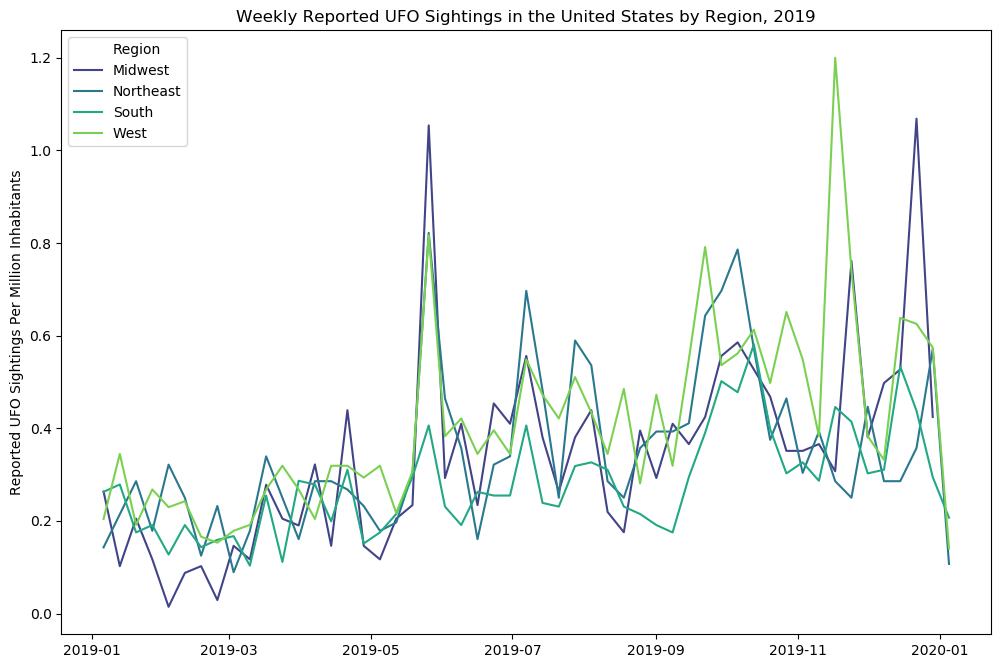

In [23]:
# 2019 - Might be interesting to see if the increasing trend correlates with more Starlink satellites in orbit
df = sightings_ratio(us_ufos, year=2019, locale='Region', filt=True, grouper='1W')
plot_regional_sighting_freq(df)

### 4.1.2 Sightings per million inhabitants by region, 2010-2020  
Next, a visual comparison of the four regions from 2010-2020. The 4th of July sightings are clearly visible between 2010 and 2015. However, the West also boasts the single largest haul of sightings in one day: on November 7th, 2015 there were 255 sightings in the West census region, highest frequency for a single day for any region in the past 10 years.

In [24]:
yr = 2014 # Adjust this to view other years (valid range: 2010-2020)
# prepare the data - group by day
df=sightings_ratio(us_ufos, year=yr, locale='Region', filt=True, grouper='1D')

# create the visualization
alt.Chart(df).mark_area().encode(
    x=alt.X('Datetime:T',title=None),
    y=alt.Y('UFOSightingsper1M:Q', title=None),
    color=alt.Color('Region:N', legend=None),
    row=alt.Row('Region:N', title=None)
).properties(height=150, width=700, title='Daily US Regional UFO Sightings Per Million Inhabitants in '+str(yr))


# Alternative: stacked area approach, pandas.plot + matplotlib
# df = sightings_ratio(us_ufos, year=2014, locale='Region', filt=True, grouper='1W')
# leg_lab=df.Region.unique() # Retrieve Region IDs for legend
# df.set_index('Datetime')[['Region', 'UFOSightingsper1M']].pivot(columns='Region').plot.area(cmap='viridis_r')
# ax.set_xlabel('')
# plt.title('Weekly Reported UFO Sightings in the United States by Region, 2014');
# plt.xlabel(None)
# plt.ylabel('Reported UFO Sightings Per Million Inhabitants');
# plt.legend(leg_lab);

alt.Chart(...)

### 4.1.3 What happened on November 7, 2015?
As the following figure demonstrates, a dramatic increase in sightings occurred in early November of 2015 in the West census region. Unlike the 4th of July reports, there is not a corresponding increase in other regions.

In [25]:
yr = 2015 # Adjust this to view other years (valid range: 2010-2020)
# prepare the data - group by day
df=sightings_ratio(us_ufos, year=yr, locale='Region', filt=True, grouper='1D')

# create the visualization
alt.Chart(df).mark_area().encode(
    x=alt.X('Datetime:T',title=None),
    y=alt.Y('UFOSightingsper1M:Q', title=None),
    color=alt.Color('Region:N', legend=None),
    row=alt.Row('Region:N', title=None)
).properties(height=150, width=700, title='Daily US Regional UFO Sightings Per Million Inhabitants in '+str(yr))

alt.Chart(...)

So what's going on with that spike in sightings in early November, 2015? They seem to be driven by California and nearby states like Arizona and Nevada. The ratio of NUFORC notes to reported UFO sightings is extremely high, indicating that most of these reports were commented on by NUFORC staff.

In [26]:
df2015=sightings_ratio(us_ufos, year=2015, locale='State', filt=True, grouper='1D')
df2015.loc[df2015.Datetime=='2015-11-7', ['NUFORC_Note','UFO_Count','State']].groupby('State').sum().sort_values('NUFORC_Note', ascending=False)

NUFORC_Note  UFO_Count
State                              
California         170.0        199
Arizona             30.0         32
Nevada               9.0         10
Utah                 5.0          5
New Mexico           3.0          3
...                  ...        ...
Indiana              0.0          2
Illinois             0.0          1
Hawaii               0.0          2
Connecticut          0.0          1
Wisconsin            0.0          4

[27 rows x 2 columns]

Upon examining the `Summary` field for sightings on 2015-11-17 in California we can see that NUFORC notes reference a US Navy missile launch. This event made news headlines at the time, as this article on [The Guardian](https://www.theguardian.com/us-news/2015/nov/08/navy-missile-launch-california-bright-light) illustrates. Searching for *US Navy Missle test* and this date results in a large number of videos of the event, such as this [example](https://www.youtube.com/watch?v=33Y5kpCQZ0g).

In [27]:
pd.set_option('display.max_colwidth',-1) # allows for viewing summaries more easily
us_ufos.loc[(us_ufos.index.date==(DT.date(2015,11,7))) & (us_ufos.NUFORC_Note==True) & (us_ufos.StateCode=='CA'), ['StateCode','Summary']]

StateCode  \
Datetime                        
2015-11-07 19:40:00  CA         
2015-11-07 19:15:00  CA         
2015-11-07 19:00:00  CA         
2015-11-07 19:00:00  CA         
2015-11-07 19:00:00  CA         
...                  ..         
2015-11-07 18:00:00  CA         
2015-11-07 18:00:00  CA         
2015-11-07 17:55:00  CA         
2015-11-07 17:55:00  CA         
2015-11-07 17:55:00  CA         

                                                                                                                                                   Summary  
Datetime                                                                                                                                                    
2015-11-07 19:40:00  object spraying a substance and had blue light. ((NUFORC Note: U. S. Navy missile launch. PD))                                         
2015-11-07 19:15:00  It hovered for several minutes then left a beam of light and a large mushroom cloud.((NUFORC Note: U. S. Navy missile launch. PD))     
2015-11-07 19:00:00  Bright lite object. ((NUFORC Note: U. S. Navy missile launch. PD))                                                                     
2015-11-07 19:00:00  Small light like a star explodes into what looks like a tiny firework. ((NUFORC Note: U. S. Navy missile launch. PD))                  
2015-11-07 19:00:00  Stratospheric Blue Light Beam tracking Orange Sun Ball. ((NUFORC Note: U. S. Navy missile launch. PD))                                 
...                                                                                                                                    ...                  
2015-11-07 18:00:00  Bright light crossing west to east then turning blue and ascending up. ((NUFORC Note: U. S. Navy missile launch. PD))                  
2015-11-07 18:00:00  Bright light illuminated the sky with a white light. The light changed color to greenish. ((NUFORC Note: US Navy missile launch. PD))  
2015-11-07 17:55:00  I looked up and saw a vapor trail from a bright moving light. Then suddenly the light turned east. ((NUFORC Note: Rocket. PD))         
2015-11-07 17:55:00  Comet-like light in the western sky, traveling south to north. ((NUFORC Note: US Navy missile launch. PD))                             
2015-11-07 17:55:00  Indio, CA, object explodes above my house. ((NUFORC Note: US Navy missile launch. PD))                                                 

[170 rows x 2 columns]

## 4.2 Yearly Sightings per million inhabitants, by state
Because looking at 50 lines would make interpretation difficult, a heatmap is used, aggregated at the yearly level. The following function allows for quick exploration of the years from 2010-2020, although 2019 and 2020 are of primary interest. Generally, it seems that the West census region has the highest overall sightings ratio, which backs up what was observed in the previous line plots by region. However, there is also an interesting cluster of states in the northeast with noticeably higher sighting ratios than other states along the east coast.

In [28]:
def us_heatmap(usdf, col='UFOSightingsper1M', cmap='Blues',
              title='Reported UFO Sightings per million inhabitants, 2019', legend_title=''):
    """
    Create a heatmap of SightingsPer1M in the United States.
    
    Inspired by: https://plotly.com/python/choropleth-maps/
    
    Arguments:
    usdf: Dataframe; result of sightings_ratio(locale='State')
    col: String; column name from usdf to use as the quantitative variable.
    cmap: String; color palette to use
    title: String; Title for the heatmap
    legend_title: String; Title to place on the colorbar/legend
    
    Example usage: 
    us_heatmap(df, title='Reported US UFO Sightings per million inhabitants, '+str(yr))
    """
    
    df = pd.merge(usdf, statesdf) # Retrieve StateCode for connectiong data to plotly's builtin maps
    # Code is slightly modified from https://plotly.com/python/choropleth-maps/
    fig = go.Figure(data=go.Choropleth(
        locations=df['StateCode'], # Spatial coordinates
        z = df[col], # Data to be color-coded
        locationmode = 'USA-states', # set of locations match entries in `locations`
        colorscale = cmap,
        colorbar_title = legend_title,
    ))

    fig.update_layout(
        title_text = title,
        geo_scope='usa', # limit map scope to USA
    )

    return fig

In [29]:
yr = 2020 # Adjust this to update the figure. Valid range: 2010-2020
df = sightings_ratio(us_ufos, year=yr, locale='State', filt=True)
us_heatmap(df, title='Reported US UFO Sightings per million inhabitants, '+str(yr), cmap='Blues')

# V. <a id='edattain'>Educational attainment</a>  
[Top](#main) 

In this section, I'll use two measures of educational attainment to examine differences in word frequency within US UFO report descriptions for the 2010-2020 timeframe.

## 5.1 US College Completion Rates  
First, we'll explore how we can combine states with similar college completion rates, to create a variable with a few categories to facilitate word cloud comparisons. `2014-2018_Overall_CCR` is the variable that best fits the time period of interest. This combines urban and rural college completion rates, though a future analysis could seek to examine them individually.

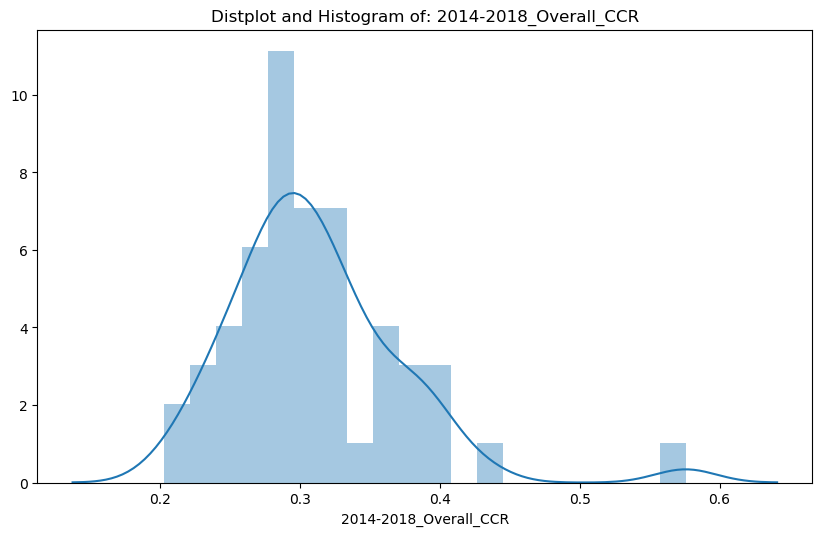

In [30]:
# Look at histogram of ccr
plt.figure(figsize=(10,6))
sns.distplot(us_colcr.iloc[:,2], bins=20) # Tertiles may be the best binning strategy?
plt.title('Distplot and Histogram of: 2014-2018_Overall_CCR');

### 5.1.1 Function defintions for CCR manipulation  
Several functions were defined, quantiles computed and bins determined based on these quantiles.

In [31]:
# Calc upper and middle tertiles
mid = us_colcr['2014-2018_Overall_CCR'].quantile(0.3333)
top = us_colcr['2014-2018_Overall_CCR'].quantile(0.6667)
    
def tert_bin(rate, t=top, m=mid):
    """
    Bin values into 3 groups.
    """
    if rate > t:
        return 2 # top third
    elif rate > m:
        return 1 # middle third
    else:
        return 0 # bottom third

us_colcr['Binned3_2014-2018_Overall_CCR'] = us_colcr.iloc[:,2].map(tert_bin)

# Join binned_colcr (ignoring other cr columns for now)
us_ufo_ed = pd.merge(us_ufos.reset_index(), us_colcr.iloc[:,[0,7]], left_on='State', right_on='Name_CCR', how='left').drop(columns=['Name_CCR'])
# Looking at just 2010-2020 aligns better to CCR estimate
us_ufo_ed = us_ufo_ed[us_ufo_ed.Datetime.dt.year >= 2010]

### 5.1.2 Tertile-binning
Next, I binned the variables into 3 categories and created the word clouds and table. In addition, I constructed a heatmap as this facilitates easy interpretation of greater differences in frequency across the educational attainment tiers.

In [32]:
# Split data based on average college completion rate
us_cr_high = us_ufo_ed[(us_ufo_ed['Binned3_2014-2018_Overall_CCR'] == 2) & ~(us_ufo_ed['Full Summary'].isnull())]
us_cr_med = us_ufo_ed[(us_ufo_ed['Binned3_2014-2018_Overall_CCR'] == 1) & ~(us_ufo_ed['Full Summary'].isnull())]
us_cr_low = us_ufo_ed[(us_ufo_ed['Binned3_2014-2018_Overall_CCR'] == 0) & ~(us_ufo_ed['Full Summary'].isnull())]

wc1 = word_cloud(us_cr_high['Full Summary'], img='ufo_im', mw=400)
wc2 = word_cloud(us_cr_med['Full Summary'], img='ufo_im', mw=400)
wc3 = word_cloud(us_cr_low['Full Summary'], img='ufo_im', mw=400)

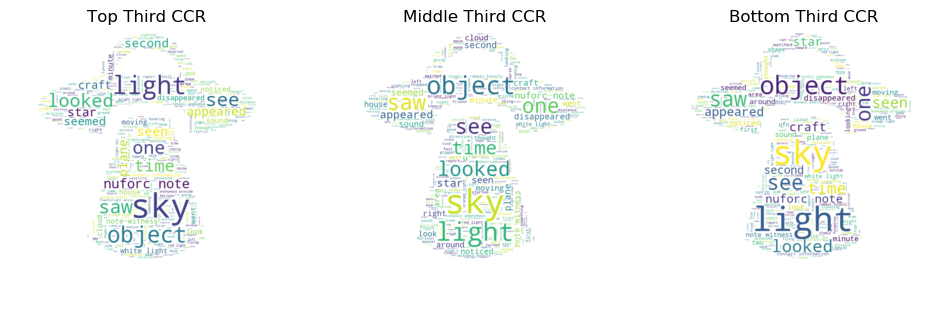

In [33]:
fig, axs = plt.subplots(ncols=3)

titles = ["Top Third CCR",
          "Middle Third CCR",
          "Bottom Third CCR"]

for ax, wc, title in zip(axs.flat, [wc1, wc2, wc3], titles):
    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(title)
# plt.savefig('wc_us_ccr.png')

The following table shows that the word frequencies are very similar overall, but there are minor differences: especially for *light*, but also *plane* vs *craft*.

In [34]:
# Create table of word frequencies
eddf1 = pd.DataFrame.from_dict(wc1.words_, orient='index').rename(columns={0:'WordWeight_TopCR'})
eddf2 = pd.DataFrame.from_dict(wc2.words_, orient='index').rename(columns={0:'WordWeight_MidCR'})
eddf3 = pd.DataFrame.from_dict(wc3.words_, orient='index').rename(columns={0:'WordWeight_BotCR'})
ccrdf = pd.merge(eddf1, eddf2, left_index=True, right_index=True, how='outer')
ccrdf = pd.merge(ccrdf, eddf3, left_index=True, right_index=True, how='outer').sort_values(by=['WordWeight_MidCR'], ascending=False)
ccrdf[0:20]

WordWeight_TopCR  WordWeight_MidCR  WordWeight_BotCR
sky          1.000000          1.000000          0.984142        
light        0.817820          0.872509          1.000000        
object       0.766978          0.780236          0.825002        
saw          0.543553          0.570146          0.567560        
see          0.534815          0.523691          0.526570        
one          0.470210          0.514133          0.516554        
looked       0.485286          0.475266          0.466475        
time         0.407778          0.433387          0.421960        
appeared     0.320581          0.333237          0.340814        
star         0.317729          0.325070          0.316146        
nuforc note  0.348108          0.321652          0.314198        
seen         0.321442          0.318524          0.358713        
plane        0.292331          0.289215          0.257999        
second       0.285223          0.287245          0.294816        
seemed       0.277255          0.279136          0.261430        
disappeared  0.263401          0.268246          0.287211        
craft        0.265257          0.267725          0.319577        
sound        0.241262          0.261701          0.253176        
noticed      0.241036          0.248842          0.249745        
went         0.229491          0.241485          0.239266

This heatmap illustrates what the table suggested more clearly. We can see that difference in *light* usage between the top and bottom college completion tiers stands out as the largest difference.

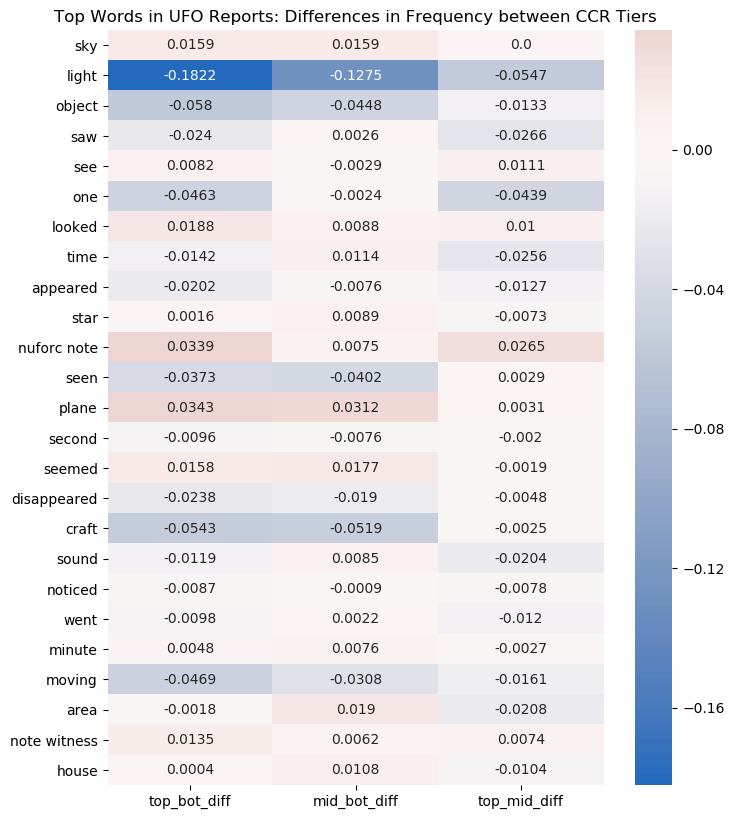

In [35]:
# Compute the differences in word frequency between educational attainment tiers
ccrdf['top_bot_diff'] = round((ccrdf.iloc[:,0] - ccrdf.iloc[:,2]), 4)
ccrdf['mid_bot_diff'] = round((ccrdf.iloc[:,1] - ccrdf.iloc[:,2]), 4)
ccrdf['top_mid_diff'] = round((ccrdf.iloc[:,0] - ccrdf.iloc[:,1]), 4)

# create heatmap of freq words with differences between tiers. Select top 25 words by mid tier freq
ccr_freq = ccrdf.sort_values('WordWeight_MidCR',ascending=False)[0:25]

plt.figure(figsize=[8, 10])
sns.heatmap(ccr_freq.iloc[:,3:], annot=True, fmt='', center=0,cmap='vlag')
plt.title('Top Words in UFO Reports: Differences in Frequency between CCR Tiers')
plt.ylim(25, 0); # Fixes padding issue
# plt.savefig('ccr_heatmap.png')

## 5.2 US Bachelor's Degree or Higher 
Next, we'll explore how `Bachelor Degree or Higher` from the `us_hsbachcr` dataset compares to `2014-2018_Overall_CCR`. Alternatively, future work could examine high school completion rates.

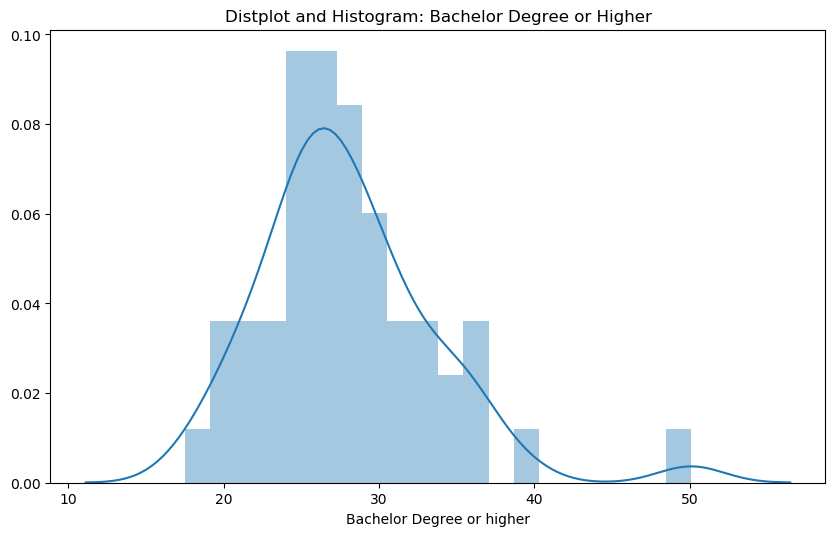

In [36]:
# First examine the distribution
plt.figure(figsize=(10,6))
sns.distplot(us_hsbachcr.iloc[:,2], bins=20)
plt.title('Distplot and Histogram: Bachelor Degree or Higher');

In [37]:
# This binning is likely too rough, given margin of error on CR estimates, and the wide variation in CR within states
# Likely more accurate to break down sightings by City, though this requires substantially more cleaning

# join us_hsbachcr
us_ufo_ed2 = pd.merge(us_ufos.reset_index(), us_hsbachcr.iloc[:,[0,2]], left_on='State', right_on='State', how='inner')
us_ufo_ed2 = us_ufo_ed2[us_ufo_ed2.Datetime.dt.year >= 2010]
    
# Calc upper and middle tertiles
mid = us_hsbachcr['Bachelor Degree or higher'].quantile(0.3333)
top = us_hsbachcr['Bachelor Degree or higher'].quantile(0.6667)

def tert_bin(rate, t=top, m=mid):
    """
    Bin values into 3 groups.
    """
    if rate > t:
        return 2 # top third
    elif rate > m:
        return 1 # middle third
    else:
        return 0 # bottom third

us_ufo_ed2['Binned_BD3'] = us_ufo_ed2['Bachelor Degree or higher'].map(tert_bin)

# Split data based on average college completion rate
us_bd_high = us_ufo_ed2[(us_ufo_ed2['Binned_BD3'] == 2) & ~(us_ufo_ed2['Full Summary'].isnull())]
us_bd_med = us_ufo_ed2[(us_ufo_ed2['Binned_BD3'] == 1) & ~(us_ufo_ed2['Full Summary'].isnull())]
us_bd_low = us_ufo_ed2[(us_ufo_ed2['Binned_BD3'] == 0) & ~(us_ufo_ed2['Full Summary'].isnull())]

In [38]:
# Create wordclouds
wc1 = word_cloud(us_bd_high['Full Summary'], img='ufo_im')
wc2 = word_cloud(us_bd_med['Full Summary'], img='ufo_im')
wc3 = word_cloud(us_bd_low['Full Summary'], img='ufo_im')

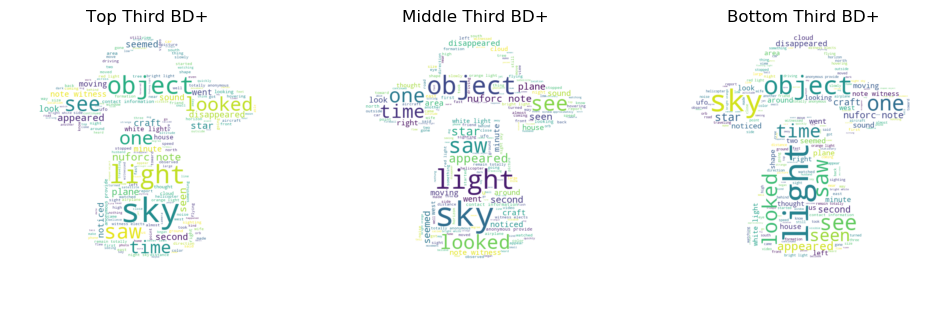

In [39]:
# Create visualizations
fig, axs = plt.subplots(ncols=3)
titles = ["Top Third BD+",
          "Middle Third BD+",
          "Bottom Third BD+"]

for ax, wc, title in zip(axs.flat, [wc1, wc2, wc3], titles):
    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(title)

In [40]:
eddf1 = pd.DataFrame.from_dict(wc1.words_, orient='index').rename(columns={0:'WordWeight_TopBD'}) # Top
eddf2 = pd.DataFrame.from_dict(wc2.words_, orient='index').rename(columns={0:'WordWeight_MidBD'}) # Mid
eddf3 = pd.DataFrame.from_dict(wc3.words_, orient='index').rename(columns={0:'WordWeight_BotBD'}) # Bottom
bddf=pd.merge(eddf1, eddf2, left_index=True, right_index=True, how='outer')
bddf=pd.merge(bddf, eddf3, left_index=True, right_index=True, how='outer').sort_values(by=['WordWeight_MidBD'], ascending=False)

# These results are very similar to what was seen in previous CCR tertile binning
bddf[0:20]

WordWeight_TopBD  WordWeight_MidBD  WordWeight_BotBD
sky          1.000000          1.000000          0.992515        
light        0.818155          0.866659          1.000000        
object       0.765457          0.787661          0.783179        
saw          0.543397          0.578432          0.557948        
see          0.525523          0.527991          0.537342        
one          0.474525          0.497342          0.535660        
looked       0.480985          0.480378          0.475357        
time         0.400214          0.433499          0.420606        
appeared     0.314925          0.333861          0.339108        
star         0.312546          0.329224          0.322372        
nuforc note  0.346690          0.323739          0.316737        
seen         0.319977          0.319328          0.351640        
second       0.281461          0.290375          0.292683        
seemed       0.273593          0.287435          0.262489        
plane        0.294089          0.286926          0.265013        
disappeared  0.261353          0.270357          0.288141        
craft        0.262373          0.264816          0.314214        
sound        0.239400          0.256786          0.258116        
noticed      0.241682          0.250565          0.251304        
minute       0.226383          0.244176          0.232128

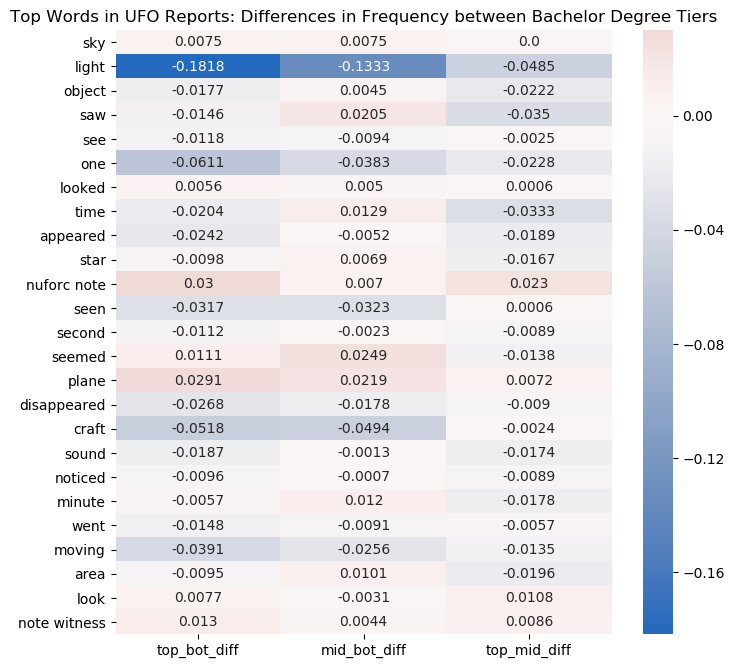

In [41]:
# Compute the differences in word frequency between educational attainment tiers
bddf['top_bot_diff'] = round((bddf.iloc[:,0] - bddf.iloc[:,2]), 4)
bddf['mid_bot_diff'] = round((bddf.iloc[:,1] - bddf.iloc[:,2]), 4)
bddf['top_mid_diff'] = round((bddf.iloc[:,0] - bddf.iloc[:,1]), 4)

# create heatmap of freq words with differences between tiers. Select top 25 words by mid tier freq
ccr_freq = bddf.sort_values('WordWeight_MidBD',ascending=False)[0:25]

plt.figure(figsize=[8, 8])
sns.heatmap(ccr_freq.iloc[:,3:], annot=True, fmt='', center=0,cmap='vlag')
plt.title('Top Words in UFO Reports: Differences in Frequency between Bachelor Degree Tiers')
plt.ylim(25, 0); # Fixes padding issue

Overall, these results are very similar to what was observed in the college completion rate analysis.

# VI. <a id='covid19si'>COVID-19 Stringency Index</a>
[Top](#main)  
  
In this section, I'll examine several variables from COVID-19 tracking data for associations with measures of UFO report frequency, such as sightings per million inhabitants.

## 6.1 Associations across the US as a whole

Exploration revealed that there were rows with missing stringency index, confirmed cases or confirmed deaths. Handling of various conditions was added to `clean_uscov`. One weak correlation was surprising, but significant nonetheless: as confirmed cases increased, UFO reports decreased. To further explore that dynamic, I derived a new weekly confirmed cases variable, though its relationship to UFO sightings was of very similar strength. Upon reflection, these are both somewhat flawed comparisons due to the nature of COVID-19 testing capacity throughout the pandemic.

In [42]:
# Determine weekly sightings, weekly SIFD by state
# Mean is crude; rolling mean would likely be a better idea
uscov_weekly=uscov_short.set_index('Date').groupby([pd.Grouper(freq='1W'), 'RegionCode']).mean().reset_index()

# Calc sightings per million, etc
usufos20w = sightings_ratio(us_ufos, year=2020, locale='State', filt=True, grouper='1W')
# Need to bring in StateCode
usufos20w = pd.merge(usufos20w, statesdf, left_on='State', right_on='State')
uscovufos = pd.merge(uscov_weekly, usufos20w, how='left', left_on=['Date','RegionCode'], right_on=['Datetime','StateCode'])

# Fill in missing values for state/week combinations that reported no sightings
uscovufos.UFO_Count.fillna(0, inplace=True)
uscovufos.UFOSightingsper1M.fillna(0, inplace=True)
uscovufos.Hoaxper1M.fillna(0, inplace=True)

# Sort data to align for calculating differences in confirmed cases by State
uscovufos.sort_values(['RegionCode', 'Date'], inplace=True)
uscovufos['WeeklyConfCases'] = np.where(uscovufos.RegionCode == uscovufos.RegionCode.shift(1), uscovufos.ConfirmedCases.diff(), 0)

# Calc correlations for variables of interest
uscovufos[['ConfirmedCases', 'ConfirmedDeaths', 'WeeklyConfCases', 'StringencyIndex', 'UFOSightingsper1M', 'Hoaxper1M']].corr()

ConfirmedCases  ConfirmedDeaths  WeeklyConfCases  \
ConfirmedCases     1.000000        0.781631         0.721902          
ConfirmedDeaths    0.781631        1.000000         0.370817          
WeeklyConfCases    0.721902        0.370817         1.000000          
StringencyIndex    0.240874        0.250125         0.250406          
UFOSightingsper1M -0.126563       -0.100931        -0.110168          
Hoaxper1M         -0.011684       -0.006097        -0.014944          

                   StringencyIndex  UFOSightingsper1M  Hoaxper1M  
ConfirmedCases     0.240874        -0.126563          -0.011684   
ConfirmedDeaths    0.250125        -0.100931          -0.006097   
WeeklyConfCases    0.250406        -0.110168          -0.014944   
StringencyIndex    1.000000         0.031088           0.009398   
UFOSightingsper1M  0.031088         1.000000           0.073325   
Hoaxper1M          0.009398         0.073325           1.000000

## 6.2 Associations by US Region  
Next, I evaluated whether there were associations when grouping the data at the regional level.

In [43]:
# Join weekly us COVID-19 data, 2019 pop estimates, 2020 US UFO reports
# Weekly aggregations allow correlations with Stringency Index, COVID19 statistics in 2020

# Keep Name, 2019 census estimates
uspop19=uspop.iloc[:,[0,-1]]
us20 = us_ufos[us_ufos.index.year == 2020].groupby([pd.Grouper(freq='1W'), 'StateCode']).sum().reset_index()

# Bring region identifers into the COVID-19 tracking data; RegionName is really a state identifier
covmerged=pd.merge(uscov_weekly, statesdf, left_on='RegionCode', right_on='StateCode').drop(columns='RegionCode')
covmerged=pd.merge(covmerged, uspop19, how='left', left_on='State', right_on='Name').drop(columns='Name')

# Combine COVID-19 tracking data with 2020 US UFO reports
usregcov=pd.merge(covmerged, us20, left_on=['Date', 'StateCode'], right_on=['Datetime', 'StateCode'])
usregcov.drop(columns=['Datetime'], inplace=True)
# Don't need to fill NaNs for Hoax, UFO_Count due to aggregation at Region level

usregcov=usregcov.groupby(['Region', 'Date']).agg({'UFO_Count':sum, 'Hoax':sum, 'Pop_2019':sum, 'ConfirmedCases':sum,
                                                   'ConfirmedDeaths':sum, 'StringencyIndex':'mean'}).reset_index()
usregcov['UFOSightingsper1M'] = usregcov['UFO_Count']/usregcov['Pop_2019']*1e6
usregcov['Hoaxper1M'] = usregcov['Hoax']/usregcov['Pop_2019']*1e6

# Create Weekly Cases by State
# usregcov = usregcov.sort_values(by=['RegionCode', 'Date']) # Sort data to align for calculating differences
usregcov['WeeklyConfCases'] = np.where(usregcov.Region == usregcov.Region.shift(1), usregcov.ConfirmedCases.diff(), 0)
# Note, odd behavior at end of timespan - becomes negative - exclude timepoints beyond 8/23
usregcov=usregcov[usregcov.set_index('Date').index.date <= pd.Timestamp(2020,8,23)]

In [44]:
usregcov[usregcov.Region=='Northeast'].corr()

UFO_Count      Hoax  Pop_2019  ConfirmedCases  \
UFO_Count          1.000000   0.141661  0.412000  0.215845         
Hoax               0.141661   1.000000  0.163480  0.083659         
Pop_2019           0.412000   0.163480  1.000000  0.008769         
ConfirmedCases     0.215845   0.083659  0.008769  1.000000         
ConfirmedDeaths    0.183994   0.070169 -0.034211  0.996963         
StringencyIndex    0.185494   0.188731  0.024326  0.720957         
UFOSightingsper1M  0.985472   0.119669  0.268148  0.204703         
Hoaxper1M          0.142555   0.999995  0.163443  0.083063         
WeeklyConfCases    0.211633   0.420760  0.649013  0.162548         

                   ConfirmedDeaths  StringencyIndex  UFOSightingsper1M  \
UFO_Count          0.183994         0.185494         0.985472            
Hoax               0.070169         0.188731         0.119669            
Pop_2019          -0.034211         0.024326         0.268148            
ConfirmedCases     0.996963         0.720957         0.204703            
ConfirmedDeaths    1.000000         0.689386         0.178580            
StringencyIndex    0.689386         1.000000         0.174081            
UFOSightingsper1M  0.178580         0.174081         1.000000            
Hoaxper1M          0.069473         0.188923         0.120580            
WeeklyConfCases    0.135734         0.318541         0.126559            

                   Hoaxper1M  WeeklyConfCases  
UFO_Count          0.142555   0.211633         
Hoax               0.999995   0.420760         
Pop_2019           0.163443   0.649013         
ConfirmedCases     0.083063   0.162548         
ConfirmedDeaths    0.069473   0.135734         
StringencyIndex    0.188923   0.318541         
UFOSightingsper1M  0.120580   0.126559         
Hoaxper1M          1.000000   0.420393         
WeeklyConfCases    0.420393   1.000000

In [45]:
usregcov[usregcov.Region=='South'].corr()

UFO_Count      Hoax  Pop_2019  ConfirmedCases  \
UFO_Count          1.000000  -0.126224  0.521246 -0.057573         
Hoax              -0.126224   1.000000  0.107745 -0.117899         
Pop_2019           0.521246   0.107745  1.000000  0.148418         
ConfirmedCases    -0.057573  -0.117899  0.148418  1.000000         
ConfirmedDeaths   -0.070239  -0.142271  0.072315  0.976164         
StringencyIndex    0.024440  -0.154469 -0.235573  0.308458         
UFOSightingsper1M  0.978859  -0.164573  0.359093 -0.102123         
Hoaxper1M         -0.126224   1.000000  0.107745 -0.117899         
WeeklyConfCases    0.069951  -0.106342  0.378966  0.795819         

                   ConfirmedDeaths  StringencyIndex  UFOSightingsper1M  \
UFO_Count         -0.070239         0.024440         0.978859            
Hoax              -0.142271        -0.154469        -0.164573            
Pop_2019           0.072315        -0.235573         0.359093            
ConfirmedCases     0.976164         0.308458        -0.102123            
ConfirmedDeaths    1.000000         0.409743        -0.107369            
StringencyIndex    0.409743         1.000000         0.070398            
UFOSightingsper1M -0.107369         0.070398         1.000000            
Hoaxper1M         -0.142271        -0.154469        -0.164573            
WeeklyConfCases    0.794594         0.301826        -0.011255            

                   Hoaxper1M  WeeklyConfCases  
UFO_Count         -0.126224   0.069951         
Hoax               1.000000  -0.106342         
Pop_2019           0.107745   0.378966         
ConfirmedCases    -0.117899   0.795819         
ConfirmedDeaths   -0.142271   0.794594         
StringencyIndex   -0.154469   0.301826         
UFOSightingsper1M -0.164573  -0.011255         
Hoaxper1M          1.000000  -0.106342         
WeeklyConfCases   -0.106342   1.000000

In [46]:
usregcov[usregcov.Region=='Midwest'].corr()

UFO_Count      Hoax  Pop_2019  ConfirmedCases  \
UFO_Count          1.000000   0.030871  0.493457 -0.212279         
Hoax               0.030871   1.000000  0.095498 -0.110786         
Pop_2019           0.493457   0.095498  1.000000  0.116413         
ConfirmedCases    -0.212279  -0.110786  0.116413  1.000000         
ConfirmedDeaths   -0.226828  -0.097624  0.118172  0.966006         
StringencyIndex    0.086037  -0.201026  0.335084  0.399363         
UFOSightingsper1M  0.984035   0.033246  0.343107 -0.251241         
Hoaxper1M          0.034370   0.999096  0.091597 -0.100814         
WeeklyConfCases    0.016940  -0.122540  0.336666  0.547983         

                   ConfirmedDeaths  StringencyIndex  UFOSightingsper1M  \
UFO_Count         -0.226828         0.086037         0.984035            
Hoax              -0.097624        -0.201026         0.033246            
Pop_2019           0.118172         0.335084         0.343107            
ConfirmedCases     0.966006         0.399363        -0.251241            
ConfirmedDeaths    1.000000         0.487821        -0.269829            
StringencyIndex    0.487821         1.000000         0.025578            
UFOSightingsper1M -0.269829         0.025578         1.000000            
Hoaxper1M         -0.085210        -0.192215         0.038356            
WeeklyConfCases    0.531686         0.337706        -0.033512            

                   Hoaxper1M  WeeklyConfCases  
UFO_Count          0.034370   0.016940         
Hoax               0.999096  -0.122540         
Pop_2019           0.091597   0.336666         
ConfirmedCases    -0.100814   0.547983         
ConfirmedDeaths   -0.085210   0.531686         
StringencyIndex   -0.192215   0.337706         
UFOSightingsper1M  0.038356  -0.033512         
Hoaxper1M          1.000000  -0.118780         
WeeklyConfCases   -0.118780   1.000000

In [47]:
usregcov[usregcov.Region=='West'].corr()

UFO_Count      Hoax  Pop_2019  ConfirmedCases  \
UFO_Count          1.000000   0.049808  0.416281 -0.082824         
Hoax               0.049808   1.000000  0.166966  0.033456         
Pop_2019           0.416281   0.166966  1.000000 -0.066862         
ConfirmedCases    -0.082824   0.033456 -0.066862  1.000000         
ConfirmedDeaths   -0.139551  -0.030866 -0.147670  0.972134         
StringencyIndex    0.193610   0.048743  0.036341  0.395728         
UFOSightingsper1M  0.999014   0.046234  0.381534 -0.078160         
Hoaxper1M          0.050893   0.999764  0.163633  0.041047         
WeeklyConfCases   -0.063585  -0.215458  0.035275  0.763285         

                   ConfirmedDeaths  StringencyIndex  UFOSightingsper1M  \
UFO_Count         -0.139551         0.193610         0.999014            
Hoax              -0.030866         0.048743         0.046234            
Pop_2019          -0.147670         0.036341         0.381534            
ConfirmedCases     0.972134         0.395728        -0.078160            
ConfirmedDeaths    1.000000         0.505023        -0.133166            
StringencyIndex    0.505023         1.000000         0.193517            
UFOSightingsper1M -0.133166         0.193517         1.000000            
Hoaxper1M         -0.023518         0.046173         0.047562            
WeeklyConfCases    0.781955         0.421785        -0.064268            

                   Hoaxper1M  WeeklyConfCases  
UFO_Count          0.050893  -0.063585         
Hoax               0.999764  -0.215458         
Pop_2019           0.163633   0.035275         
ConfirmedCases     0.041047   0.763285         
ConfirmedDeaths   -0.023518   0.781955         
StringencyIndex    0.046173   0.421785         
UFOSightingsper1M  0.047562  -0.064268         
Hoaxper1M          1.000000  -0.215926         
WeeklyConfCases   -0.215926   1.000000

Rather than look at all of these tables individually, I extracted the key relationships from each region and assembled a datframe for use in the following heatmap.

### 6.2.1 Heatmap & Key findings for the period from 1/1/20 to 8/23/20:

The following findings are based on removing weeks of 8/30 and 9/6 which had incomplete data in one or more datasets.

Interestingly, within the Northeast region, there is a mild positive correlation between `ConfirmedCases` and `UFOSightingsper1M`, while the South, Midwest and West see mild negative correlations. It should be noted that the Northeast bore the brunt of the COVID-19 outbreak in March-April, having the highest number of deaths at a time when reported UFO sightings for the year were highest overall. When examining weekly confirmed cases and `UFOSightingsPer1M`, all regions have a positive association, though it is fairly weak in the Midwest and West.

In [48]:
# combined table with reduced features, for inclusion in final report
corr_cols = ['ConfirmedCases', 'ConfirmedDeaths', 'WeeklyConfCases', 'StringencyIndex']
# retain sightings per million correlations with selected COVID-19 features
ne_corr = usregcov[usregcov.Region=='Northeast'].corr().loc['UFOSightingsper1M',corr_cols].rename('Northeast')
so_corr = usregcov[usregcov.Region=='South'].corr().loc['UFOSightingsper1M',corr_cols].rename('South')
mw_corr = usregcov[usregcov.Region=='Midwest'].corr().loc['UFOSightingsper1M',corr_cols].rename('Midwest')
we_corr = usregcov[usregcov.Region=='West'].corr().loc['UFOSightingsper1M',corr_cols].rename('West')
# Create table for plotting
c19corr = pd.concat([ne_corr, so_corr, mw_corr, we_corr], axis=1)

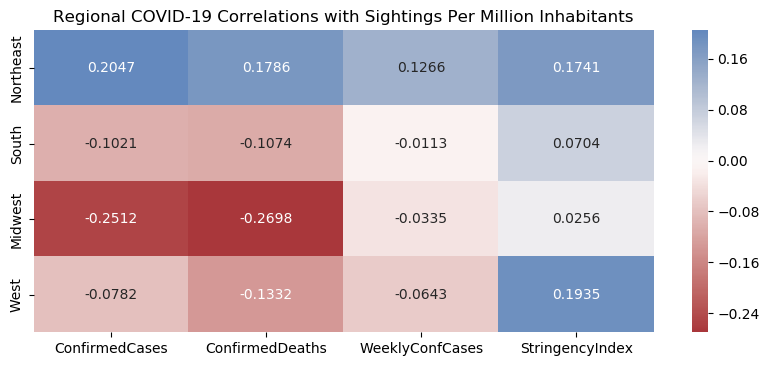

In [49]:
# generate a heatmap
plt.figure(figsize=[10, 4])
sns.heatmap(round(c19corr.transpose(), 4), annot=True, fmt='', center=0, cmap='vlag_r')
plt.title('Regional COVID-19 Correlations with Sightings Per Million Inhabitants')
plt.ylim(4, 0); # Fixes padding issue
plt.yticks(verticalalignment='center');
# plt.savefig('reg_c19_heatmap.png')

# VII. <a id='supplemental'>Supplemental Analyses</a>  
[Top](#main) 

This section contains a variety of exploratory analyses that were not used in the final project report.

## 7.1 Hoaxes 

I derived the `Hoax` label from any `Summary` description which contained the word *hoax*, which was almost always enclosed within one or more parentheses and seems to have been added by NUFORC staff. I am not aware of the criteria that was used for determine what was a hoax and what wasn't.

### 7.1.1 Hoaxes per million inhabitants
The Northeastern region, and Vermont in particular, have a high rate of hoaxes (as identified by NUFORC) compared to other areas. As with sightings per million inhabitants, a heatmap is an effective visual tool for exploring this variable. There are not enough consistent non-zero values for a line graph to be of much benefit. Generally, there seems to be a high degree of stochasticity in hoaxes within a given state from year to year. However, upon examining heatmaps from 2010-2020, Vermont stands out as having an unusual number of hoaxes.

In [50]:
yr = 2018 # Adjust the year value [2010-2020] to examine other hoax ratios
df = sightings_ratio(us_ufos, year=yr, locale='State', filt=True)
us_heatmap(df, title='US UFO Hoaxes per million inhabitants, '+str(yr), col='Hoaxper1M', cmap='Blues')

### 7.1.2 Word Cloud Comparison: Hoaxes vs Non-Hoaxes
In future work, I'll compare the words used in US UFO reports denoted as hoaxes against all other reports.

## 7.2 Shape analysis
Although providing less detail than report descriptions, the `Shape` field could nonetheless reveal differences across regions, states, or other grouping variables.

### 7.2.1 Create a revised shape column, condensing the number of categories

In [51]:
# Create a function to reduce the number of shape categories
def shape_relabel(shape):
    """
    Collapse UFO Shape identifiers into similar categories
    """
    # Consider grouping diamond, rectangle under 'quadrilateral'
    # cylinder + cone ? or should cone be grouped under triangular?
    if shape in ['Circle', 'Sphere', 'Oval', 'Egg', 'Teardrop']:
        return 'Circular/Spherical'
    elif shape in ['Cigar', 'Disk']:
        return 'Disk-like'
#     elif shape in ['Fireball', 'Flash']:
#         return 'meteor-like'
    elif (pd.isnull(shape)) | (shape=='Unknown'):
        return 'Missing/Unknown' # Consider whether these are better split into two categories
    elif shape in ['Triangle', 'TRIANGULAR', 'Chevron', 'Cone']: # roughly triangular
        return 'Triangular'
    elif shape in ['Rectangle', 'Diamond']:
        return 'Quadrilateral'
    else:
        return shape


ufo_df['Shape_rev'] = ufo_df['Shape'].map(lambda x: shape_relabel(x))
ufo_df.Shape_rev.value_counts()

Circular/Spherical    22855
Light                 19731
Triangular            9584 
Missing/Unknown       9583 
Fireball              7259 
Disk-like             6758 
Other                 6087 
Formation             3189 
Quadrilateral         3020 
Changing              2246 
Flash                 1726 
Cylinder              1420 
Cross                 318  
Name: Shape_rev, dtype: int64

In [52]:
ufo_df.Shape.value_counts()

Light         19731
Circle        10866
Triangle      8227 
Fireball      7259 
Unknown       6475 
              ...  
Teardrop      806  
Egg           699  
Cone          361  
Cross         318  
TRIANGULAR    1    
Name: Shape, Length: 22, dtype: int64

### 7.2.2 Yearly US reports of US sightings by shape  
*Light* is the most common shape descriptor, although if the shapes are aggregated into similar groups, it's clear that circular/spherical shapes are also common. In the second plot, we also see that if missing shape descriptions are paired with *unknown* values, it becomes the third most common category.

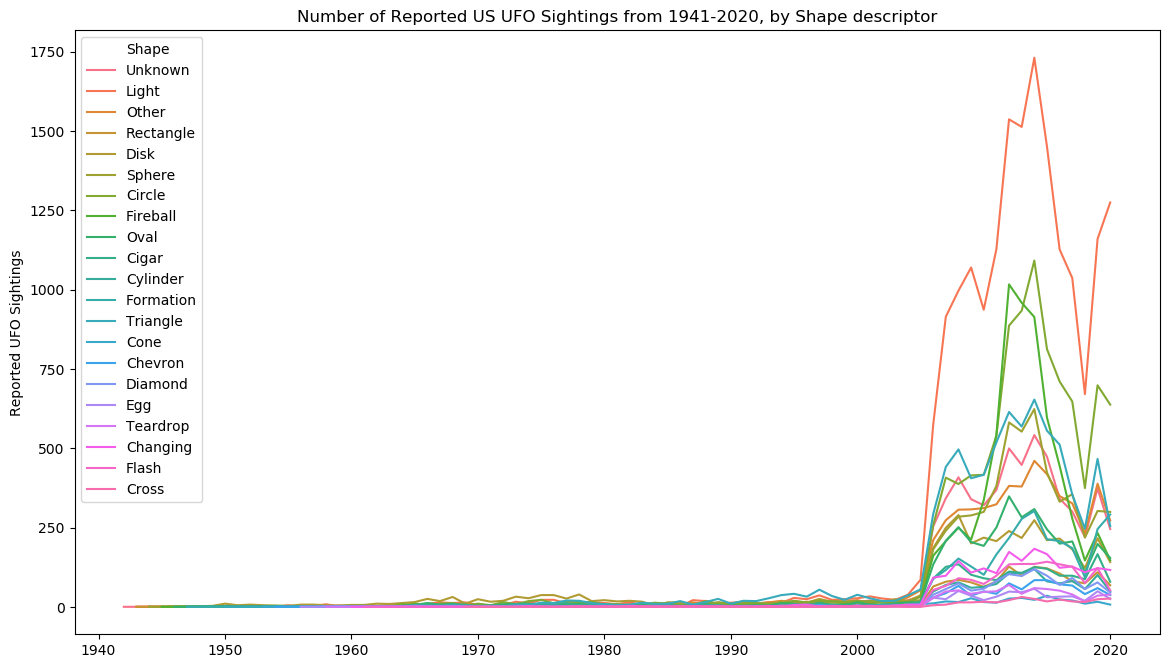

In [53]:
# show num sightings per year: aggregate by Year, Shape
us_ufos_yearly = prep_us_ufos(ufo_df, states=statesdf, startyr=1941, endyr=2020) # 1941-2020
us_ufos_yearly = us_ufos_yearly.groupby([pd.Grouper(freq='1Y'), 'Shape']).agg(np.sum).reset_index()
us_ufos_yearly['Year'] = us_ufos_yearly.Datetime.dt.year

# Consider using shape vs shape_rev
plt.figure(figsize=(14,8))
ax = sns.lineplot(x='Year', y='UFO_Count', hue='Shape', data=us_ufos_yearly)
ax.set_ylabel('Reported UFO Sightings')
ax.set_xlabel(None)
ax.set_title('Number of Reported US UFO Sightings from 1941-2020, by Shape descriptor');

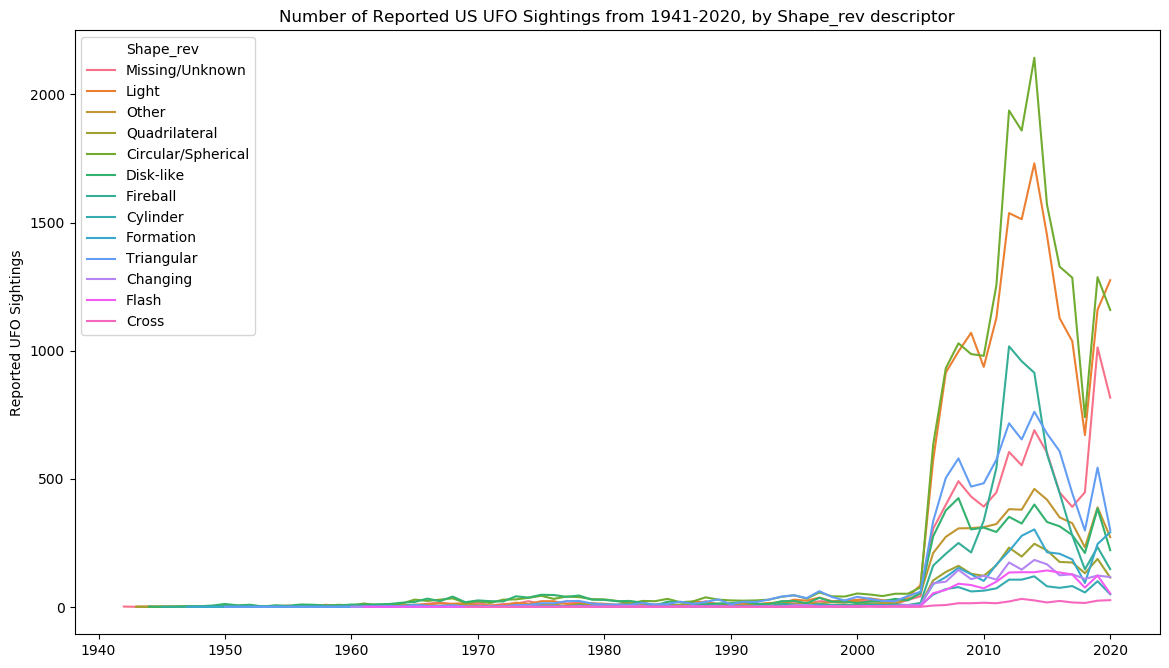

In [54]:
# show num sightings per year: aggregate by Year, Shape_rev
us_ufos_yearly = prep_us_ufos(ufo_df, states=statesdf, startyr=1941, endyr=2020) # 1941-2020
us_ufos_yearly = us_ufos_yearly.groupby([pd.Grouper(freq='1Y'), 'Shape_rev']).agg(np.sum).reset_index()
us_ufos_yearly['Year'] = us_ufos_yearly.Datetime.dt.year

plt.figure(figsize=(14,8))
ax = sns.lineplot(x='Year', y='UFO_Count', hue='Shape_rev', data=us_ufos_yearly)
ax.set_ylabel('Reported UFO Sightings')
ax.set_xlabel(None)
ax.set_title('Number of Reported US UFO Sightings from 1941-2020, by Shape_rev descriptor');